In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [61]:
# create a table for numeric df to see the averaged of each category on who survived and who didnt
# doing this with the purpose of getting a rough idea of what categories imply a higher chance of survival

In [60]:
# we do something similar to the previous step but we have to do it for every separated category.
class_table = pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = ['Ticket'], aggfunc = 'count')
sex_table = pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = ['Ticket'], aggfunc = 'count')
embarked_table = pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = ['Ticket'], aggfunc = 'count')
print(class_table)
print(sex_table)
print(embarked_table)

         Ticket         
Pclass        1   2    3
Survived                
0            80  97  372
1           136  87  119
         Ticket     
Sex      female male
Survived            
0            81  468
1           233  109
         Ticket         
Embarked      C   Q    S
Survived                
0            75  47  427
1            93  30  217


In [14]:
# from the previous two code boxes we can get a better understanding of what we can use to grab a better estimate of who survived 
# and who didnt. It seems like people from higher classes, females, people with pricier tickets, and people who embarked in C had the 
# best survival rate.

In [15]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
# Create separate df for categorical and numerical values
num_df = train_df[['Age', 'SibSp', 'Parch', 'Fare']]
cat_df = train_df[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

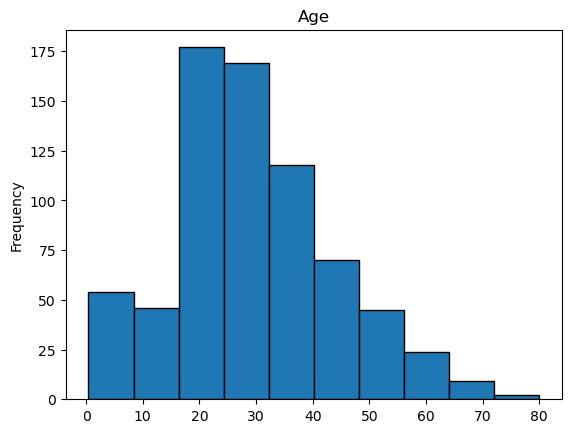

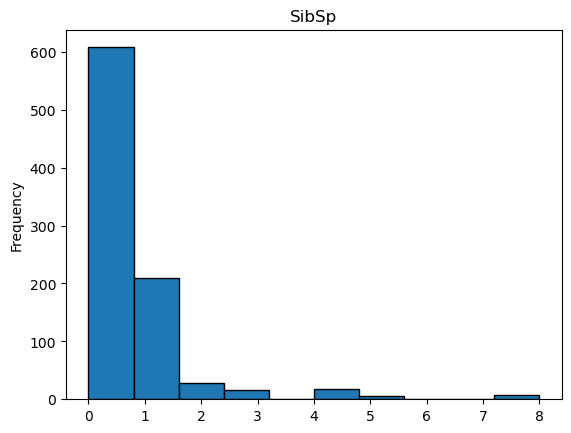

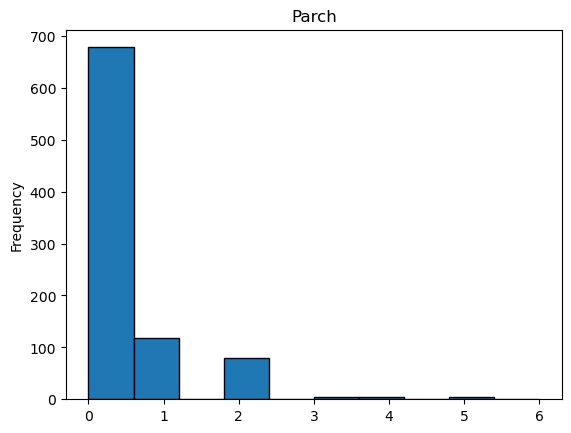

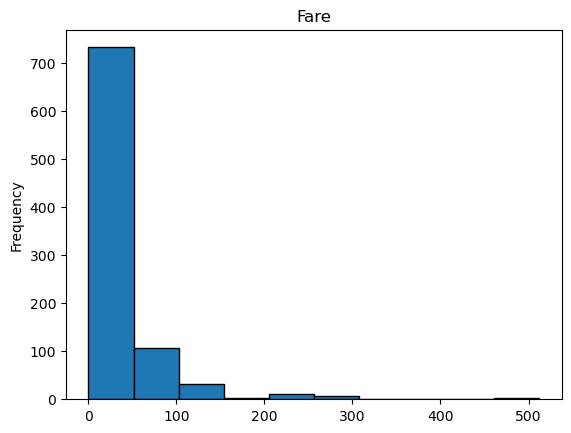

In [20]:
# show a histogram for all the columns in numeric values data frame to see how data is distributed.
for column in num_df:
    plt.figure()
    num_df[column].plot.hist(bins = 10, edgecolor = 'black')
    plt.title(column)
    plt.show()

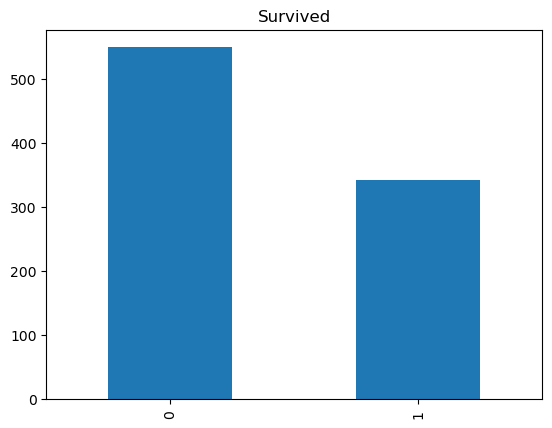

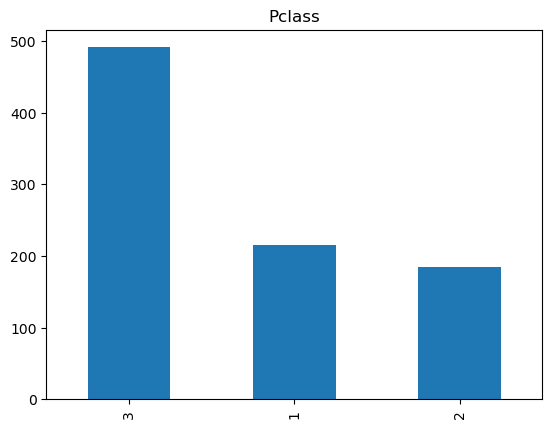

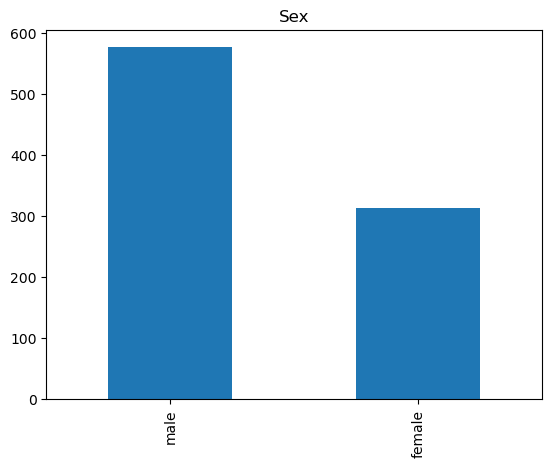

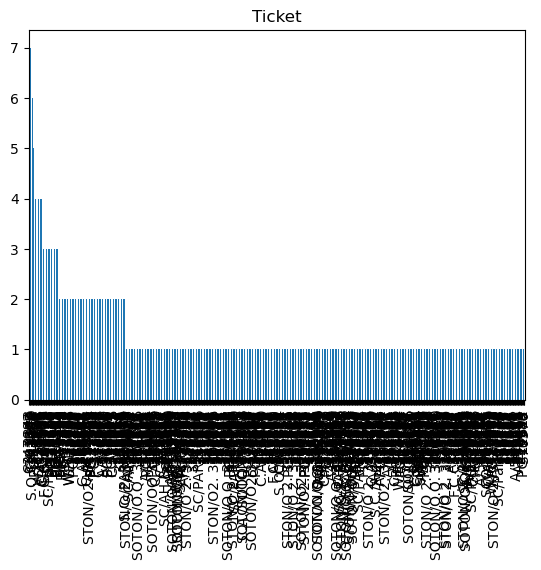

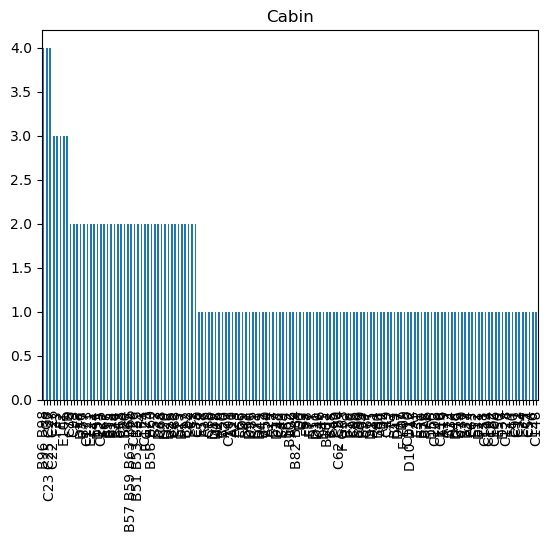

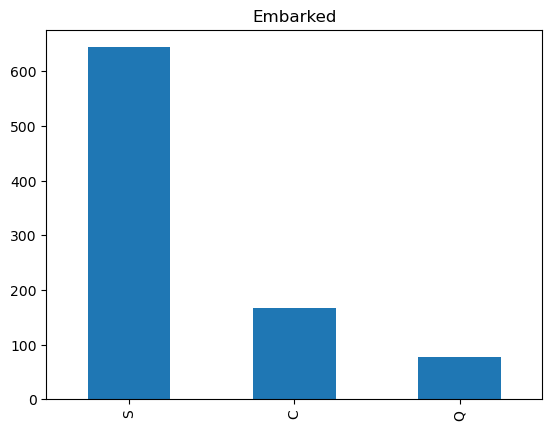

In [32]:
# do the same but for categorical
for column in cat_df:
    plt.figure()
    value_count = cat_df[column].value_counts()
    value_count.plot.bar()
    plt.title(column)
    plt.show()

In [33]:
# with these graphs we get a good understanding of the distributions that we are dealing with and we now fet to normalize the
# data to obtain better results.

In [42]:
# we check to see if there was people with multiple cabins and we want to check if that is correlated with survival.
train_df['Cabin_Count'] = train_df['Cabin'].fillna('').str.split(' ').apply(lambda x: len(x) if x != [''] else 0)
train_df['Cabin_Count'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: Cabin_Count, dtype: int64

In [43]:
# next we make a pivot table to compare the amount of cabins people had with their survival rate
cabin_pivot = pd.pivot_table(train_df, index = 'Survived', columns = 'Cabin_Count', values = ['Ticket'], aggfunc = 'count')
print(cabin_pivot)

            Ticket                      
Cabin_Count      0      1    2    3    4
Survived                                
0            481.0   58.0  7.0  3.0  NaN
1            206.0  122.0  9.0  3.0  2.0


In [40]:
# from what we can see, the people who had more cabins had a higher rate of survival.

In [49]:
# now we will check the first letter of the cabin as maybe this affects the location where the cabin was compared to escape
# routes or maybe even the ammenities/services for them were better and led to priority in terms of escaping.
train_df['cabin_letter'] = train_df['Cabin'].apply(lambda x : str(x)[0])
print(train_df['cabin_letter'].value_counts())

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_letter, dtype: int64


In [55]:
# next we make a pivot table to compare the amount of cabins people had with their survival rate
letter_pivot = pd.pivot_table(train_df, index = 'Survived', columns = 'cabin_letter', values = ['Ticket'], aggfunc = 'count')
print(letter_pivot)

             Ticket                                              
cabin_letter      A     B     C     D     E    F    G    T      n
Survived                                                         
0               8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1               7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0


In [56]:
# shows that certain cabins have a higher survival rate (particularly D and E)

In [80]:
# I will check the prefix of tickets and see of that has any correlation with the survival rate
# maybe the prefix indicates different ticketing agencies or higher prices in these.

train_df['number_tickets'] = train_df['Ticket'].apply(lambda x : 1 if x.isnumeric() else 0)
# Print the nuber of tickets with only numbers
print(train_df['number_tickets'].value_counts())

1    661
0    230
Name: number_tickets, dtype: int64


In [82]:
pd.pivot_table(train_df, index = 'Survived', columns = 'number_tickets', values = ['Ticket'], aggfunc = 'count')

Ticket     
number_tickets      0    1
Survived                  
0                 142  407
1                  88  254

In [ ]:
# There is no sign of a strong correlation or even any correlation between if the ticket is numeric and the person survived.

In [83]:
train_df['Letter_tickets'] = train_df['Ticket'].apply(lambda x : ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
print(train_df['Letter_tickets'].value_counts())

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: Letter_tickets, dtype: int64


In [88]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Letter_tickets', values = ['Ticket'], aggfunc = 'count')

Ticket                                                    ...  \
Letter_tickets      0   a4    a5   as    c    ca casoton   fa   fc  fcc  ...   
Survived                                                                 ...   
0               410.0  7.0  19.0  1.0  3.0  27.0     1.0  1.0  1.0  1.0  ...   
1               255.0  NaN   2.0  NaN  2.0  14.0     NaN  NaN  NaN  4.0  ...   

                                                                          
Letter_tickets  soc  sop sopp sotono2 sotonoq   sp stono2 swpp   wc  wep  
Survived                                                                  
0               5.0  1.0  3.0     2.0    13.0  1.0   10.0  NaN  9.0  2.0  
1               1.0  NaN  NaN     NaN     2.0  NaN    8.0  2.0  1.0  1.0  

[2 rows x 29 columns]

In [86]:
# Once again there does not seem to be any correlation between tickets and survival rate so we might just discard
# this column when we try to solve the problem.

In [89]:
# Next we are going to go by titles and see if that has any influence in their survival rate
train_df['name_title'] = train_df["Name"].apply(lambda x : x.split(',')[1].split('.')[0].strip())
print(train_df['name_title'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64


In [90]:
pd.pivot_table(train_df, index = 'Survived', columns = 'name_title', values = ['Ticket'], aggfunc = 'count')

Ticket                                                             \
name_title   Capt  Col  Don   Dr Jonkheer Lady Major Master   Miss Mlle  Mme   
Survived                                                                       
0             1.0  1.0  1.0  4.0      1.0  NaN   1.0   17.0   55.0  NaN  NaN   
1             NaN  1.0  NaN  3.0      NaN  1.0   1.0   23.0  127.0  2.0  1.0   

                                                     
name_title     Mr   Mrs   Ms  Rev  Sir the Countess  
Survived                                             
0           436.0  26.0  NaN  6.0  NaN          NaN  
1            81.0  99.0  1.0  NaN  1.0          1.0

In [92]:
# There is a trend where females and people with "powerful" titles have a higher rate of survival.

In [94]:
# we are going to start cleaning our data to begin setting up the model, we will combine both files to clean easier
merged_df = pd.concat([train_df, test_df])

In [112]:
# replace/remove null values
merged_df.dropna(subset = ['Embarked'], inplace = True)
merged_df['Age'] = merged_df['Age'].fillna(train_df['Age'].mean())

In [136]:
# Create the same variables that we had made for train_df in merged_df
merged_df['Cabin_Count'] = merged_df['Cabin'].fillna('').str.split(' ').apply(lambda x: len(x) if x != [''] else 0)
merged_df['cabin_letter'] = merged_df['Cabin'].apply(lambda x : str(x)[0])
merged_df['number_tickets'] = merged_df['Ticket'].apply(lambda x : 1 if x.isnumeric() else 0)
merged_df['Letter_tickets'] = merged_df['Ticket'].apply(lambda x : ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
merged_df['name_title'] = merged_df["Name"].apply(lambda x : x.split(',')[1].split('.')[0].strip())
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1307 non-null   int64  
 1   Survived        889 non-null    float64
 2   Pclass          1307 non-null   object 
 3   Name            1307 non-null   object 
 4   Sex             1307 non-null   object 
 5   Age             1307 non-null   float64
 6   SibSp           1307 non-null   int64  
 7   Parch           1307 non-null   int64  
 8   Ticket          1307 non-null   object 
 9   Fare            1307 non-null   float64
 10  Cabin           293 non-null    object 
 11  Embarked        1307 non-null   object 
 12  Cabin_Count     1307 non-null   int64  
 13  cabin_letter    1307 non-null   object 
 14  number_tickets  1307 non-null   int64  
 15  Letter_tickets  1307 non-null   object 
 16  name_title      1307 non-null   object 
dtypes: float64(3), int64(5), object(9)

In [161]:
# normalize some of the data for more accurate results and put it in a new data frame
scaler = StandardScaler()
norm_df = merged_df.copy()
norm_df[['Age', 'Parch', 'Fare', 'SibSp']] = scaler.fit_transform(merged_df[['Age', 'Parch', 'Fare', 'SibSp']])

In [162]:
# convert categorical data into dummy variables.
merged_df['Pclass'] = merged_df['Pclass'].astype(str)
dummies = pd.get_dummies(merged_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_Count', 'cabin_letter', 'number_tickets', 'name_title', 'testing']])

In [165]:
# create training and test sets
train_df['testing'] = 1
test_df['testing'] = 0
merged_df = pd.concat([train_df, test_df])
x_train = dummies[dummies.testing == 1].drop(['testing'], axis = 1)
x_test = dummies[dummies.testing == 0].drop(['testing'], axis = 1)
y_train = merged_df[merged_df.testing == 1].Survived

In [173]:
# Use cross validation to check accuracy of our sets
gnb = GaussianNB()
cross_val = cross_val_score(gnb, x_train, y_train, cv = 20)
print(cross_val)
print(cross_val.mean())

[0.73333333 0.66666667 0.68888889 0.73333333 0.62222222 0.82222222
 0.68888889 0.77777778 0.91111111 0.66666667 0.8        0.70454545
 0.72727273 0.86363636 0.75       0.70454545 0.77272727 0.72727273
 0.72727273 0.84090909]
0.7464646464646465


In [ ]:
# Got a 75% accuracy. That's a C in a regular class and a B in a bunch of engineering classes. I will call this a huge
# success and go to bed considering that it is currently 4am.